In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import math
import random

## Create toy dataset

In [13]:
class Dataset:
    def __init__(self, *args, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


def create_train_val_test_indices(n_train, n_val, n_test):
    n_tot = n_train + n_val + n_test
    split = list(np.random.permutation(n_tot))
    train_indices, val_indices, test_indices = split[:n_train], split[n_train:n_train + n_val], split[n_train + n_val:]
    return train_indices, val_indices, test_indices

    
def split_dataset(X, Y1, Y2, n_train, n_val, n_test):
    train_indices, val_indices, test_indices = create_train_val_test_indices(N_train, N_val, N_test)
    train = Dataset(
        X=torch.tensor(X[train_indices,:], dtype=torch.float), 
        Y1=torch.tensor(Y1[train_indices], dtype=torch.float), 
        Y2=torch.tensor(Y2[train_indices], dtype=torch.float)
    )
    val = Dataset(
        X=torch.tensor(X[val_indices,:], dtype=torch.float), 
        Y1=torch.tensor(Y1[val_indices], dtype=torch.float), 
        Y2=torch.tensor(Y2[val_indices], dtype=torch.float)
    )
    test = Dataset(
        X=torch.tensor(X[test_indices,:], dtype=torch.float), 
        Y1=torch.tensor(Y1[test_indices], dtype=torch.float), 
        Y2=torch.tensor(Y2[test_indices], dtype=torch.float)
    )
    return train, val, test


seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N_train, N_val, N_test = 8000, 1000, 1000
N = N_train + N_val + N_test

M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 

u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2

train, val, test = split_dataset(X, Y1, Y2, N_train, N_val, N_test)

In [15]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

Weightloss1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)

params = [Weightloss1, Weightloss2]
MTL = MTLnet()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam(params, lr=LR)
loss_func = nn.MSELoss()
Gradloss = nn.L1Loss()

/home/rlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [30]:
YE1.shape

torch.Size([100])

Iter-0; MTL loss: 0.8869
Iter-1; MTL loss: 0.7416
Iter-2; MTL loss: 0.4151
Iter-3; MTL loss: 0.3544
Iter-4; MTL loss: 0.3032
Iter-5; MTL loss: 0.3241
Iter-6; MTL loss: 0.2834
Iter-7; MTL loss: 0.2725
Iter-8; MTL loss: 0.3352
Iter-9; MTL loss: 0.2447
Iter-10; MTL loss: 0.2862
Iter-11; MTL loss: 0.2803
Iter-12; MTL loss: 0.249
Iter-13; MTL loss: 0.193
Iter-14; MTL loss: 0.2674
Iter-15; MTL loss: 0.2407
Iter-16; MTL loss: 0.2159
Iter-17; MTL loss: 0.2302
Iter-18; MTL loss: 0.2021
Iter-19; MTL loss: 0.2168
Iter-20; MTL loss: 0.2254
Iter-21; MTL loss: 0.2219
Iter-22; MTL loss: 0.1787
Iter-23; MTL loss: 0.1962
Iter-24; MTL loss: 0.2096
Iter-25; MTL loss: 0.2094
Iter-26; MTL loss: 0.2797
Iter-27; MTL loss: 0.2212
Iter-28; MTL loss: 0.2007
Iter-29; MTL loss: 0.1943
Iter-30; MTL loss: 0.2185
Iter-31; MTL loss: 0.2204
Iter-32; MTL loss: 0.2178
Iter-33; MTL loss: 0.202
Iter-34; MTL loss: 0.2269
Iter-35; MTL loss: 0.2216
Iter-36; MTL loss: 0.1795
Iter-37; MTL loss: 0.1804
Iter-38; MTL loss: 0.1976

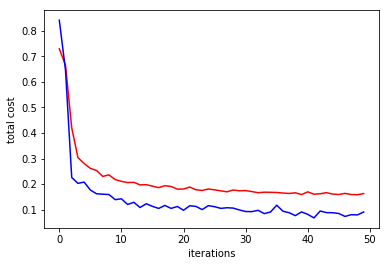

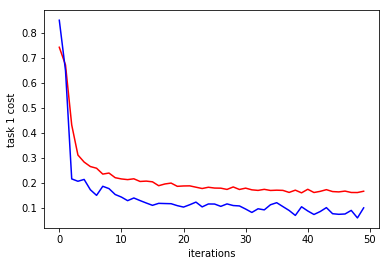

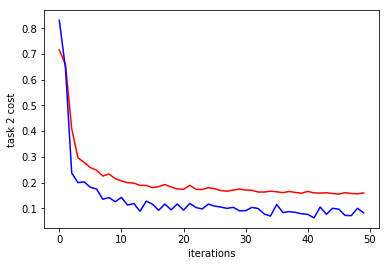

In [16]:
alph = 0.16
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size / mb_size)
    minibatches = random_mini_batches(train.X, train.Y1, train.Y2, mb_size)
    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2 = minibatch

        Yhat1, Yhat2 = MTL(XE)
        l1 = params[0] * loss_func(Yhat1, YE1.view(-1, 1))
        l2 = params[1] * loss_func(Yhat2, YE2.view(-1, 1))
        loss = torch.div(torch.add(l1, l2), 2)

        # for the first epoch with no l0
        if it == 0:
            l0 = loss.data

        opt1.zero_grad()

        loss.backward(retain_graph=True)

        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        param = list(MTL.parameters())
        G1R = torch.autograd.grad(l1, param[0], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[0], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2)
        G_avg = torch.div(torch.add(G1, G2), 2)

        # Calculating relative losses 
        lhat1 = torch.div(l1, l0)
        lhat2 = torch.div(l2, l0)
        lhat_avg = torch.div(torch.add(lhat1, lhat2), 2)

        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1, lhat_avg)
        inv_rate2 = torch.div(lhat2, lhat_avg)

        # Calculating the constant target for Eq. 2 in the GradNorm paper
        C1 = G_avg * (inv_rate1) ** alph
        C2 = G_avg * (inv_rate2) ** alph
        C1 = C1.detach()
        C2 = C2.detach()

        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.add(Gradloss(G1, C1), Gradloss(G2, C2))
        Lgrad.backward()

        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 2 / torch.add(Weightloss1, Weightloss2)
        params = [coef * Weightloss1, coef * Weightloss2]
        # print("Weights are:",Weightloss1, Weightloss2)
        # print("params are:", params)
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)

    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))

    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(val.X)
        l1D = params[0] * loss_func(Yhat1D, val.Y1.view(-1, 1))
        l2D = params[1] * loss_func(Yhat2D, val.Y2.view(-1, 1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.div(torch.add(l1D, l2D), 2))
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))
        # print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))

plt.plot(np.squeeze(costtr), '-r', np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show()

plt.plot(np.squeeze(cost1tr), '-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.show()

plt.plot(np.squeeze(cost2tr), '-r', np.squeeze(cost2D), '-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.show()

In [5]:
print(params)

[tensor([1.0190], grad_fn=<MulBackward0>), tensor([0.9810], grad_fn=<MulBackward0>)]


In [6]:
costtr

[tensor(0.7081, grad_fn=<MeanBackward1>),
 tensor(0.6564, grad_fn=<MeanBackward1>),
 tensor(0.5003, grad_fn=<MeanBackward1>),
 tensor(0.3427, grad_fn=<MeanBackward1>),
 tensor(0.3035, grad_fn=<MeanBackward1>),
 tensor(0.2752, grad_fn=<MeanBackward1>),
 tensor(0.2527, grad_fn=<MeanBackward1>),
 tensor(0.2406, grad_fn=<MeanBackward1>),
 tensor(0.2242, grad_fn=<MeanBackward1>),
 tensor(0.2174, grad_fn=<MeanBackward1>),
 tensor(0.2107, grad_fn=<MeanBackward1>),
 tensor(0.2085, grad_fn=<MeanBackward1>),
 tensor(0.2094, grad_fn=<MeanBackward1>),
 tensor(0.1989, grad_fn=<MeanBackward1>),
 tensor(0.2001, grad_fn=<MeanBackward1>),
 tensor(0.1954, grad_fn=<MeanBackward1>),
 tensor(0.1856, grad_fn=<MeanBackward1>),
 tensor(0.1899, grad_fn=<MeanBackward1>),
 tensor(0.1855, grad_fn=<MeanBackward1>),
 tensor(0.1805, grad_fn=<MeanBackward1>),
 tensor(0.1841, grad_fn=<MeanBackward1>),
 tensor(0.1782, grad_fn=<MeanBackward1>),
 tensor(0.1723, grad_fn=<MeanBackward1>),
 tensor(0.1729, grad_fn=<MeanBackw